All NaNs have been handled.
Computed class weights: {0: 0.624753154141525, 1: 2.5039573485764537}
Filtered class weights: {0: 0.624753154141525, 1: 2.5039573485764537}
Epoch 1/100
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6955 - loss: 0.6518 - val_accuracy: 0.8037 - val_loss: 0.4977 - learning_rate: 0.0010
Epoch 2/100
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8010 - loss: 0.5094 - val_accuracy: 0.8037 - val_loss: 0.4967 - learning_rate: 0.0010
Epoch 3/100
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7978 - loss: 0.5085 - val_accuracy: 0.8037 - val_loss: 0.4956 - learning_rate: 0.0010
Epoch 4/100
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8004 - loss: 0.5029 - val_accuracy: 0.8037 - val_loss: 0.4967 - learning_rate: 0.0010
Epoch 5/100
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8047 - loss: 0.4964 - val_accuracy: 0.8037 - val_loss: 0.4956 - learning_rate: 0.0010
Epoch 6/100
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - 

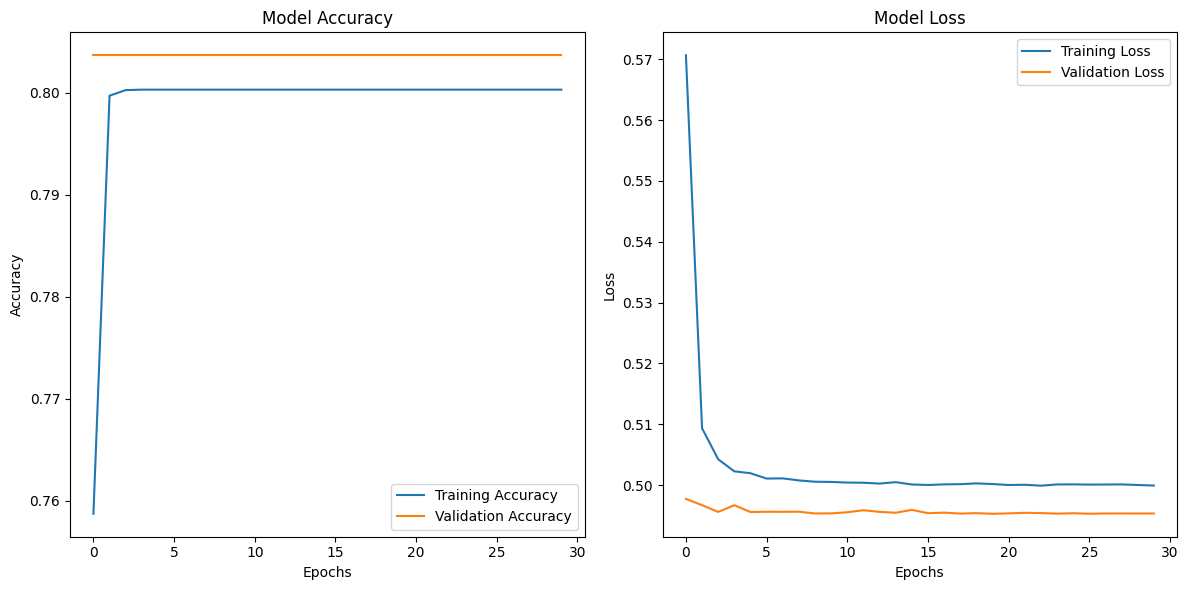

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - accuracy: 0.8055 - loss: 0.4926
Test Accuracy: 80.37%


In [11]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Load the dataset
data = pd.read_csv('D:/Data science classes slides pdf/Football_analysis/football_analytics_injury_prevention/processed/merged_data_with_features.csv')

# Feature selection - only retain features with valid data
valid_features = ['age', 'height']  # Simplified to only include non-dropped columns
X = data[valid_features]

# Ensure all features are numeric and handle errors during conversion
X = X.apply(pd.to_numeric, errors='coerce')

# Handle any remaining NaNs by filling with the median
X.fillna(X.median(), inplace=True)

# Final check for NaNs
if X.isnull().sum().any():
    print("Warning: There are still NaNs in the feature matrix after filling missing values.")
else:
    print("All NaNs have been handled.")

# Target variable
y = data['Injury'].replace({'Yes': 1, 'No': 0})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute class weights to handle any imbalance in the data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Computed class weights:", class_weights)

# Check if class weights match y_train classes
valid_class_weights = {key: class_weights[key] for key in np.unique(y_train)}
print("Filtered class weights:", valid_class_weights)

# Model definition - simple architecture to isolate issues
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# Compile the model with a learning rate scheduler and Adam optimizer with weight decay
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping and learning rate reduction on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model without class weights to isolate issues
try:
    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test),
                        callbacks=[early_stopping, reduce_lr], batch_size=32)
except KeyError as e:
    print(f"KeyError encountered: {e}")
    print(f"Unique values in y_train: {np.unique(y_train)}")
    print(f"Class weights: {class_weights}")
except Exception as e:
    print(f"An error occurred during model training: {e}")

# Save the model only if training was successful
if history is not None:
    model.save('D:/Data science classes slides pdf/Football_analysis/football_analytics_injury_prevention/models/dense_model_improved.keras')

    # Visualize training history
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
else:
    print("Model training did not complete, skipping evaluation.")


In [1]:
%pip install xgboost lightgbm catboost


   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   - -------------------------------------- 2.9/101.1 MB 16.7 MB/s eta 0:00:06
   -- ------------------------------------- 6.8/101.1 MB 17.5 MB/s eta 0:00:06
   ---- ----------------------------------- 11.8/101.1 MB 19.4 MB/s eta 0:00:05
   ------ --------------------------------- 16.5/101.1 MB 20.4 MB/s eta 0:00:05
   ------- -------------------------------- 19.9/101.1 MB 20.0 MB/s eta 0:00:05
   --------- ------------------------------ 23.3/101.1 MB 18.9 MB/s eta 0:00:05
   ---------- ----------------------------- 27.8/101.1 MB 19.1 MB/s eta 0:00:04
   ------------ --------------------------- 31.5/101.1 MB 18.8 MB/s eta 0:00:04
   -------------- ------------------------- 35.7/101.1 MB 19.0 MB/s eta 0:00:04
   --------------- ------------------------ 40.1/101.1 MB 19.3 MB/s eta 0:00:04
   ----------------- ---------------------- 44.3/101.1 MB 19.4 MB/s eta 0:00:03
   ------------------- -------------------- 49.3/10

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier


In [5]:
# Load your dataset
data = pd.read_csv('D:/Data science classes slides pdf/Football_analysis/football_analytics_injury_prevention/data/processed/merged_data_with_features.csv')

# Define features and target variable
X = data.drop(columns=['Injury'])  # Assuming 'Injury' is the target variable
y = data['Injury']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


C:\Users\Neethiarasu\AppData\Local\Temp\ipykernel_29340\1156502033.py:2: DtypeWarning: Columns (72) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('D:/Data science classes slides pdf/Football_analysis/football_analytics_injury_prevention/data/processed/merged_data_with_features.csv')


In [6]:
categorical_columns = X_train.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns)


Categorical columns: Index(['name', 'full_name', 'nationality', 'place_of_birth', 'foot',
       'contract_expires', 'joined_club', 'player_agent', 'outfitter',
       'MATCH_DATE', 'LEAGUE_NAME', 'LEAGUE', 'FINISHED', 'LOCATION',
       'MATCHDAY', 'HOME_TEAM_NAME', 'HOME_TEAM', 'HOME_ICON',
       'AWAY_TEAM_NAME', 'AWAY_TEAM', 'AWAY_ICON'],
      dtype='object')


In [9]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoders = {}

# Apply label encoding to each categorical feature
for col in categorical_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    
    # Handle unseen labels by using a special value (e.g., -1)
    X_test[col] = X_test[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    
    label_encoders[col] = le  # Save the label encoder for future use


In [10]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))


c:\Users\Neethiarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:35:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9582967515364355


In [11]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test, xgb_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, xgb_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      9154
           1       0.99      0.79      0.88      2236

    accuracy                           0.96     11390
   macro avg       0.97      0.90      0.93     11390
weighted avg       0.96      0.96      0.96     11390

Confusion Matrix:
[[9144   10]
 [ 465 1771]]


In [13]:
# Clean the feature names
X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

# Check the cleaned feature names
print(X_train.columns)

# Now fit the LightGBM model
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)
print("LightGBM Accuracy:", accuracy_score(y_test, lgb_pred))


Index(['Unnamed_0_player', 'name', 'full_name', 'age', 'height', 'nationality',
       'place_of_birth', 'price', 'max_price', 'position', 'shirt_nr', 'foot',
       'club', 'contract_expires', 'joined_club', 'player_agent', 'outfitter',
       'Subject', 'FileName', 'Age', 'Height', 'Mass', 'Gender', 'Dominance',
       'Level', 'Experience', 'SessionsPerWk', 'Treadmill', 'Aslphalt',
       'Grass', 'Trail', 'Sand', 'Concrete', 'SurfaceAlt', 'RunGrp', 'Volume',
       'Pace', 'RaceDist', 'InjuryLoc', 'DiagnosticMed', 'Diagnostic',
       'InjuryOnDate', 'ShoeSize', 'ShoeBrand', 'ShoeModel', 'ShoePairs',
       'ShoeChange', 'ShoeComfort', 'ShoeInsert', 'RFSI25', 'RFSI35', 'RFSI45',
       'LFSI25', 'LFSI35', 'LFSI45', 'RThomas', 'LThomas', 'ROber', 'LOber',
       'RHIPABD', 'LHIPABD', 'RHIPEXT', 'LHIPEXT', 'RHIPER', 'LHIPER',
       'RHIPIR', 'Unnamed_0_match', 'MATCH_DATE', 'LEAGUE_NAME', 'SEASON',
       'LEAGUE', 'FINISHED', 'LOCATION', 'VIEWER', 'MATCHDAY', 'MATCHDAY_NR',
       

In [14]:
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)
print("CatBoost Accuracy:", accuracy_score(y_test, cat_pred))


CatBoost Accuracy: 0.9592625109745391


In [15]:
models = {
    "XGBoost": xgb_pred,
    "LightGBM": lgb_pred,
    "CatBoost": cat_pred
}

for name, pred in models.items():
    print(f"\n{name} Model Evaluation:")
    print("Accuracy:", accuracy_score(y_test, pred))
    print("Classification Report:\n", classification_report(y_test, pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, pred))



XGBoost Model Evaluation:
Accuracy: 0.9582967515364355
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      9154
           1       0.99      0.79      0.88      2236

    accuracy                           0.96     11390
   macro avg       0.97      0.90      0.93     11390
weighted avg       0.96      0.96      0.96     11390

Confusion Matrix:
 [[9144   10]
 [ 465 1771]]

LightGBM Model Evaluation:
Accuracy: 0.9591747146619842
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98      9154
           1       1.00      0.79      0.88      2236

    accuracy                           0.96     11390
   macro avg       0.98      0.90      0.93     11390
weighted avg       0.96      0.96      0.96     11390

Confusion Matrix:
 [[9154    0]
 [ 465 1771]]

CatBoost Model Evaluation:
Accuracy: 0.9592625109745391
Classification Report:
             

: 